# SMS Spam Detection

In most cases spam is just annoing. In some cases it can cause a lot of damage, especially when someone is distracted. Even if people are aware of spam, it can be very harmfull for various reasons. 
Hence, each spam SMS detected before it reaches it's destination can help people to suffer from the consequences.


Tiago Almeida and Jos Hidalgo provide a Data set with lots of example data from SMS which are spam or not. 



## Data Set collection

The dataset was collected by Tiago Almeida and Jos Hidalgo. They were contributing the data set to the following website:
https://archive.ics.uci.edu/dataset/228/sms+spam+collection


The following part was copied from the readme file and explains how the data is composed.

This corpus has been collected from free or free for research sources at the Web:

- A collection of between 425 SMS spam messages extracted manually from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: http://www.grumbletext.co.uk/
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Theses available at http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf
- A subset of 3,375 SMS ham messages of the NUS SMS Corpus (NSC), which is a corpus of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/
- The amount of 1,002 SMS ham messages and 322 spam messages extracted from the SMS Spam Corpus v.0.1 Big created by José María Gómez Hidalgo and public available at: http://www.esp.uem.es/jmgomez/smsspamcorpus/


## Reference Study

We offer a comprehensive study of this corpus in the following paper that is under review. This work presents a number of statistics, studies and baseline results for several machine learning methods.

[1] Almeida, T.A., Gómez Hidalgo, J.M., Yamakami, A. Contributions to the study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (ACM DOCENG'11), Mountain View, CA, USA, 2011. (Under review)

## EDA

### Load libraries

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

### Load the data

At first, I want to import the data.

In [4]:

df_spam = pd.read_csv("SMSSpamCollection", sep='\t', header=None, names=['label', 'Text'])

print(df_spam)

     label                                               Text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5567  spam  This is the 2nd time we have tried 2 contact u...
5568   ham               Will ü b going to esplanade fr home?
5569   ham  Pity, * was in mood for that. So...any other s...
5570   ham  The guy did some bitching but I acted like i'd...
5571   ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


The file contains 5572 lines with data. The data column specifies wheater the SMS is spam, or not. The text column contains the text message sent by the user.

Since the website already confirms, that there is no missing data, I will not check for that.

Next, I will take a look at the length of the messages.

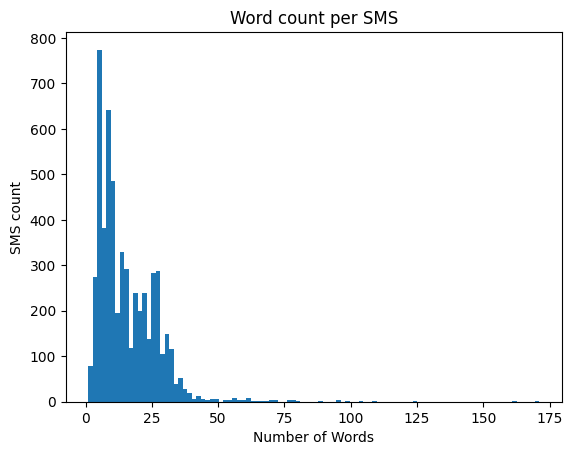

In [5]:
df_wordcount = df_spam['Text'].str.split().str.len()

plt.hist(df_wordcount, bins=100)
plt.xlabel('Number of Words')
plt.ylabel('SMS count')
plt.title('Word count per SMS')
plt.show()

In the histogram one can see that there are a few SMS consting of more than 50 words.

They can be considered outliers and thus will be examined more closely.
I will separate them from the other data set and count how many of them are spam or ham.


In [6]:
mask = df_wordcount > 50
df_MuchText = df_spam.where(mask).dropna(how='all')

count = df_MuchText['label'].value_counts(sort=False)
print('Number of labels specified as ham: ')
print(count)
print('\n')
print(df_MuchText)


Number of labels specified as ham: 
label
ham    63
Name: count, dtype: int64


     label                                               Text
53     ham  Wow. I never realized that you were so embaras...
155    ham  You are everywhere dirt, on the floor, the win...
381    ham  I guess that's why you re worried. You must kn...
551    ham  Imagine you finally get to sink into that bath...
711    ham  Height of Confidence: All the Aeronautics prof...
...    ...                                                ...
5129   ham  Rose for red,red for blood,blood for heart,hea...
5209   ham  I know you are thinkin malaria. But relax, chi...
5264   ham  Storming msg: Wen u lift d phne, u say "HELLO"...
5515   ham  You are a great role model. You are giving so ...
5535   ham  I know you are thinkin malaria. But relax, chi...

[63 rows x 2 columns]


All of these longer SMS are ham. 

Now I want to take a look if there is a correlation between the word length and the label. 

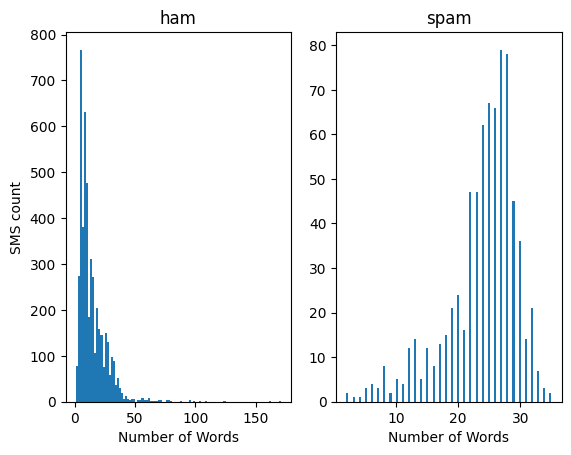

In [7]:
# Separate the ham and spam
df_ham = df_spam[df_spam['label'] == 'ham']
df_spamOnly = df_spam[df_spam['label'] == 'spam']
# Create Wordcounts
df_wordcount_ham = df_ham['Text'].str.split().str.len()
df_wordcount_spam = df_spamOnly['Text'].str.split().str.len()

# Create fist
plt.subplot(1, 2, 1)
plt.hist(df_wordcount_ham, bins=100)
plt.xlabel('Number of Words')
plt.ylabel('SMS count')
plt.title('ham')
# Create second plot
plt.subplot(1, 2, 2)
plt.hist(df_wordcount_spam, bins=100)
plt.xlabel('Number of Words')
plt.title('spam')
# display plot
plt.show()

The two histograms do not support the suspicion that the word count correlates wheater the SMS is spam or not.

## Model building and training

In my opinion agglomerative clustering should yield a very good result. This is why I want to try this algorithm to predict weather a SMS is spam or not.<br>
In this project I want to include 2 otheer learning methods to compare them with the agglomerative approach. The other unsupervised approaches is k means clustering. To compare it with a supervised method i will also create a logistic regression. We learned about it in the previous course. 


### Preprocess the data

I will convert the label to binary data and the text to features the models can work with. To get the features I will use Tfidf vectorizer.

In [11]:
# Replace ham with 0 and spam with 1 using mapping

mapping = {
    'ham' : 0,
    'spam' : 1
}

y_spam = df_spam['label'].map(mapping)

#y_spam.head()
y_spam.shape

(5572,)

In [12]:
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(stop_words="english")

# get the article-feature matrix
x_spam = tfidf_vectorizer.fit_transform(df_spam['Text']).toarray()
x_spam.shape

(5572, 8444)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_spam, y_spam, test_size=0.2, random_state=42)

### Agglomerative Clustering

In [ ]:
model = AgglomerativeClustering()


param_grid = {
    'n_clusters': [2],
    'linkage': ['ward', 'complete', 'average', 'singe']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Accuracy score:  0.8573991031390135


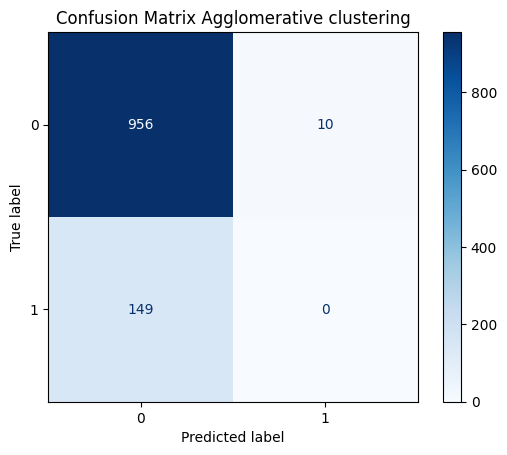

In [44]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(X_train)

y_pred_agg = clustering.fit_predict(X_test)

# Calculate accuracy score
acc_nmf = accuracy_score(y_test, y_pred_agg)
print("Accuracy score: ", acc_nmf)

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred_agg)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Agglomerative clustering')
plt.show()


### K means

In [ ]:
model = KMeans()

param_grid = {
    'n_clusters': [2],
    'init': ['k-means++', 'random'],
    'algorithm': ['lloyd', 'elkan']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'algorithm': 'elkan', 'init': 'k-means++', 'n_clusters': 2}
Best score: 0.8406813526394992


Accuracy score:  0.8762331838565023


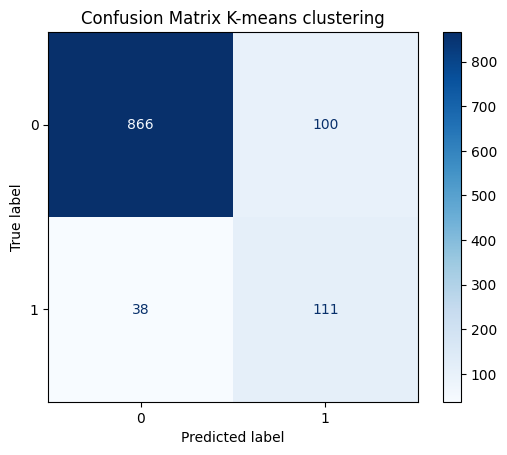

In [42]:
clustering = KMeans(n_clusters=2, init='k-means++', algorithm='elkan', random_state=42).fit(X_train)

y_pred_kme = clustering.fit_predict(X_test)

# Calculate accuracy score
acc_nmf = accuracy_score(y_test, y_pred_kme)
print("Accuracy score: ", acc_nmf)

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred_kme)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix K-means clustering')
plt.show()

### Logistic Regression

In [31]:
model = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.8, 0.6],
    'solver': ['liblinear', 'saga']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9477231205930756


Accuracy score:  0.9659192825112107


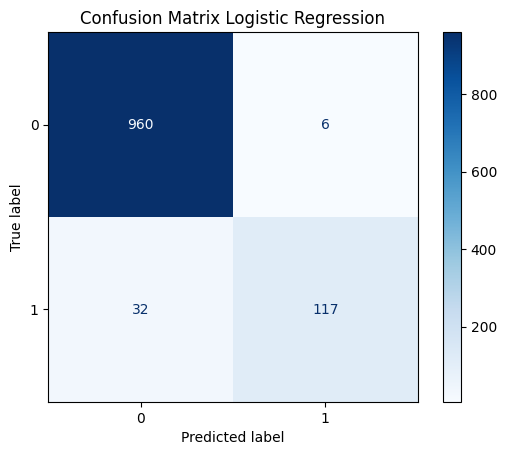

In [45]:
clustering = LogisticRegression(penalty='l1', C=1.0, solver='liblinear').fit(X_train, y_train)

y_pred_LoRe = clustering.predict(X_test)

# Calculate accuracy score
acc_nmf = accuracy_score(y_test, y_pred_LoRe)
print("Accuracy score: ", acc_nmf)

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred_LoRe)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix Logistic Regression')
plt.show()

## Discussion

The EDA has shown, that there is no correlation between the word count in a SMS and wheater it is spam or not. <br>

In the preprocessing step we converted the labels into binary output and vectorized the text into a feature matrix.<br>

#### Agglomerative Clustering
In the beginning of this project I thought agglomerative clustering would be a very good idea to detect spam. Given the test results it is not good at all! <br>
The Accuracy might be not too bad, but this is only due to the imbalanced data set. The model did not detect a single spam SMS.

#### K-Means Clustering
The accuracy of k-means is a bit better than agglomerative clustering. It also did detect most of the spam SMS.<br>
On the downside it also misslabeled a lot of the ham SMS. If I would use this model in a real application this would be very annoing not to receive that many SMS that are in fact ok.
For me this model is not suited for this case as well.

#### Logistic regression
As we were told in the previous course, supervised learning, Logistic regression is a good method to detect spam. <br>
In this case it detected three quater of the actual spam SMS and only labeled less than 1% as spam where it wasn't.
I would not consider this a very good model, but it is a good start for further feature development.
